In [5]:
import os
import sys
import glob
import math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dir = Path("models")
print(f"Running on: {device}")

# Load Reference Data for comparison
ref_file = Path("tfim_4x4_fidelity_ref.csv")
if ref_file.exists():
    print("Reference data found.")
    ref_df = pd.read_csv(ref_file)
else:
    print("Warning: Reference CSV not found. Plot will contain model data only.")
    ref_df = None

Running on: cpu


In [6]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        fe_v = term1_v - term2_v
        fe_flipped = term1_f - term2_f

        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator, burn_in: int = 50):
        cond = cond.to(device)
        if cond.dim() == 1: cond = cond.expand(n_samples, -1)
        b_mod, c_mod = self._compute_effective_biases(cond)

        probs = torch.full((n_samples, self.num_visible), 0.5, device=device)
        v = torch.bernoulli(probs, generator=rng)

        for _ in range(burn_in):
            v = self._gibbs_step(v, b_mod, c_mod, rng)
        return v

In [8]:
def load_latest_model():
    # glob returns strings
    pt_files = sorted(glob.glob(str(models_dir / "*.pt")), key=os.path.getmtime, reverse=True)
    if not pt_files:
        raise FileNotFoundError("No .pt files found in models directory.")

    # Convert string to Path object here
    latest_path = Path(pt_files[0])
    print(f"Loading: {latest_path.name}")

    checkpoint = torch.load(latest_path, map_location=device)
    config = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=config["num_visible"],
        num_hidden=config["num_hidden"],
        cond_dim=1,
        k=config.get("k_steps", 1),
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    return model, config

model, config = load_latest_model()
h_support = config.get("h_support", [])
print(f"Support Points: {h_support}")

Loading: crbm_tfim_4x4_50000_20251210_223015.pt
Support Points: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


In [11]:
def compute_susceptibility_qgt(model, h_val, n_samples=20000):
    """
    Computes chi_F using the Variance of Gradients (Quantum Geometric Tensor).
    chi_F = Var( d/dh log_psi )
    """
    # Grab the model's specific dtype (usually float32)
    model_dtype = next(model.parameters()).dtype

    # 1. Generate Samples at h_val
    rng = torch.Generator(device=device).manual_seed(42)

    with torch.no_grad():
        # FIX: Explicitly use model_dtype
        cond_fixed = torch.tensor([[h_val]], device=device, dtype=model_dtype)
        samples = model.generate(cond_fixed, n_samples, rng, burn_in=100)

    # 2. Prepare Condition Batch with Gradients Enabled
    # FIX: Explicitly use model_dtype
    cond_batch = torch.full((n_samples, 1), h_val, device=device, dtype=model_dtype, requires_grad=True)

    # 3. Compute Log Scores (Computation Graph)
    log_psi = model.log_score(samples, cond_batch)

    # 4. Compute Gradients w.r.t h
    # We want d(log_psi)/dh for EACH sample.
    # standard .backward() sums gradients. To get per-sample gradients efficiently,
    # we use autograd.grad with a ones-tensor, relying on the fact that
    # the Jacobian is diagonal (sample i only depends on condition i).
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch,
        grad_outputs=torch.ones_like(log_psi),
        create_graph=False
    )[0]

    # grads shape is (N, 1). Flatten to (N,)
    local_ops = grads.squeeze()

    # 5. Compute Variance
    # chi_F = <O^2> - <O>^2
    chi = torch.var(local_ops, unbiased=True)

    return chi.item()

In [12]:
# Create dense sweep for smooth curve
h_eval = np.linspace(1.5, 4.5, 40)
chi_values = []

print(f"Calculating Fidelity Susceptibility (QGT Method)...")

for h in h_eval:
    # h is numpy.float64, but the fix in Cell 4 handles the cast now.
    chi = compute_susceptibility_qgt(model, h, n_samples=20000)
    chi_values.append(chi)

    # Print progress near critical point
    if 2.9 < h < 3.1:
        print(f"h={h:.2f} | chi={chi:.4f}")

print("Calculation Complete.")

Calculating Fidelity Susceptibility (QGT Method)...
h=2.96 | chi=0.4600
h=3.04 | chi=0.3689
Calculation Complete.


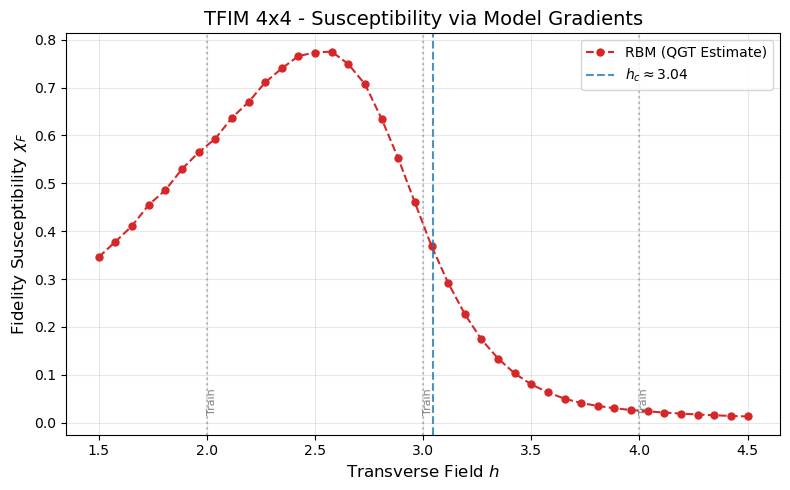

In [13]:
plt.figure(figsize=(8, 5), dpi=100)

# 1. Plot Reference (Exact Diagonalization)
if ref_df is not None:
    plt.plot(ref_df["h"], ref_df["chi_F"], '-', color='black', alpha=0.5, linewidth=2, label="Exact Reference")

# 2. Plot RBM Result
plt.plot(h_eval, chi_values, 'o--', color='tab:red', markersize=5, label="RBM (QGT Estimate)")

# 3. Mark Support Points
ymin, ymax = plt.ylim()
for h_supp in h_support:
    if 1.5 <= h_supp <= 4.5:
        plt.axvline(h_supp, color='gray', linestyle=':', alpha=0.5)
        plt.text(h_supp, ymin + (ymax-ymin)*0.05, 'Train', rotation=90, verticalalignment='bottom', color='gray', fontsize=8)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM 4x4 - Susceptibility via Model Gradients", fontsize=14)

# Theoretical Critical Point
plt.axvline(3.044, color="tab:blue", linestyle="--", alpha=0.8, label=r"$h_c \approx 3.04$")

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()